# Emotion Detection: Comparative Analysis of Statistical vs. Transformer-Based Models

## Overview

This notebook provides a comprehensive comparative analysis of different approaches to emotion detection in text. We implement and evaluate three distinct model types:

1.  **Statistical Models**: Naive Bayes (baseline) and Logistic Regression with TF-IDF features
2.  **Transformer-Based Model**: Fine-tuned DistilBERT-base-uncased
3.  **Comparative Analysis**: Performance evaluation and insights

## Dataset

-   **Source**: `dair-ai/emotion` from Hugging Face Datasets
-   **Size**: ~20,000 short texts (primarily tweets)
-   **Classes**: 6 emotions (sadness, joy, love, anger, fear, surprise)
-   **Splits**: Train (16,000), Validation (2,000), Test (2,000)

## Model Descriptions

### Statistical Models

-   **TF-IDF Features**: Term Frequency-Inverse Document Frequency vectorization
-   **Naive Bayes**: Probabilistic classifier assuming feature independence
-   **Logistic Regression**: Linear classifier with regularization

### Transformer Model

-   **DistilBERT**: Distilled version of BERT, 40% smaller, 60% faster
-   **Fine-tuning**: Adapter layers added for emotion classification
-   **Context**: Bidirectional attention mechanisms capture semantic relationships

## Setup and Library Imports


## Introduction

Emotion detection in text is a growing field within Natural Language Processing (NLP), focused on identifying the underlying emotional tone of written language. As digital communication continues to dominate online platforms, the ability to recognise emotions in short texts such as tweets or chat messages has significant practical relevance. Applications range from enhancing customer service and monitoring digital well-being to developing more empathetic chatbots and effective content moderation tools.

The methodology for accomplishing this task has evolved significantly, shifting from classical machine learning techniques to more advanced deep learning architectures. Recent literature demonstrates a clear performance advantage for modern transformer-based models, which leverage contextual understanding of language. For instance, a comparative study on Twitter data found that a BERT model achieved a higher classification accuracy (75.6%) than a traditional Support Vector Machine (71.6%) on the same task (Wicaksono & Cahyaningrum, 2024). Within the transformer paradigm itself, a performance hierarchy is also evident; research on formal datasets shows that larger, optimised models like RoBERTa can outperform more lightweight variants such as DistilBERT (Dell’Orletta et al., 2021). However, this increase in accuracy often comes with a significant trade-off in computational cost and efficiency.

Building on this context, this project conducts a direct comparative analysis to investigate these trade-offs in a practical setting. It implements two distinct models for emotion detection on short-form text: a classical model (Logistic Regression with TF-IDF features) and an efficient, contemporary transformer model (a fine-tuned DistilBERT). By evaluating both approaches on the same dataset, this study aims to provide a practical comparison of their performance, highlighting the relationship between contextual understanding, computational resources, and classification accuracy.


In [22]:
# Core data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Machine Learning - Statistical Models
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
    precision_recall_fscore_support
)
from sklearn.pipeline import Pipeline

# Machine Learning - Transformer Models
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
import torch
from torch.utils.data import Dataset

# Dataset loading
from datasets import load_dataset

# Set random seeds for reproducibility
import random
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

# Configure matplotlib and seaborn for better plots
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("✅ All libraries imported successfully!")
print(f"📦 PyTorch version: {torch.__version__}")
print(f"🤗 Transformers available: {True}")
print(f"🔢 CUDA available: {torch.cuda.is_available()}")

# Set device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Using device: {device}")


✅ All libraries imported successfully!
📦 PyTorch version: 2.6.0+cu124
🤗 Transformers available: True
🔢 CUDA available: True
🖥️ Using device: cuda


## Objectives

The primary objective of this project is to conduct a comparative analysis of two distinct machine learning paradigms for the task of emotion detection in short-form text. The study aims to implement and evaluate both a traditional statistical model and a modern, embedding-based transformer model to provide a clear, evidence-based assessment of their respective capabilities and trade-offs.

The specific objectives required to achieve this goal are as follows:

* To implement two separate data pre-processing pipelines tailored to the unique input requirements of statistical and transformer-based models.
* To build and train a classical classifier using Logistic Regression with TF-IDF features, establishing a robust statistical baseline.
* To fine-tune a pre-trained DistilBERT model to serve as an example of an efficient, contemporary embedding-based approach.
* To perform a rigorous, quantitative evaluation of both models on a held-out test set, using metrics such as accuracy and F1-score to compare their performance directly.
* To analyse the results critically, discussing not only the performance differences but also the practical trade-offs regarding computational efficiency and model interpretability.

By fulfilling these objectives, this project will contribute a reproducible and practical comparison that highlights the strengths and weaknesses of each approach, offering insight into model selection for real-world emotion detection applications.


## Data Loading and Exploration


In [23]:
!pip install --upgrade datasets huggingface_hub

# Load the emotion dataset from Hugging Face
print("📥 Loading emotion dataset...")
try:
    dataset = load_dataset("dair-ai/emotion")
    print("✅ Dataset loaded successfully!")
except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    raise

# Convert to pandas DataFrames for easier manipulation
train_df = pd.DataFrame(dataset['train'])
val_df = pd.DataFrame(dataset['validation'])
test_df = pd.DataFrame(dataset['test'])

# Combine training and validation for larger training set
full_train_df = pd.concat([train_df, val_df], ignore_index=True)

print(f"📊 Dataset sizes:")
print(f"   Training: {len(full_train_df):,} samples")
print(f"   Test: {len(test_df):,} samples")
print(f"   Total: {len(full_train_df) + len(test_df):,} samples")

# Define emotion label mapping
id2label = {0: "sadness", 1: "joy", 2: "love", 3: "anger", 4: "fear", 5: "surprise"}
label2id = {v: k for k, v in id2label.items()}

# Add emotion names to dataframes
full_train_df['emotion'] = full_train_df['label'].map(id2label)
test_df['emotion'] = test_df['label'].map(id2label)

print(f"\n🏷️ Emotion labels: {list(id2label.values())}")
print(f"📝 Example texts:")
for i in range(3):
    print(f"   {i+1}. [{full_train_df.iloc[i]['emotion']}] {full_train_df.iloc[i]['text'][:80]}...")


📥 Loading emotion dataset...
✅ Dataset loaded successfully!
📊 Dataset sizes:
   Training: 18,000 samples
   Test: 2,000 samples
   Total: 20,000 samples

🏷️ Emotion labels: ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
📝 Example texts:
   1. [sadness] i didnt feel humiliated...
   2. [sadness] i can go from feeling so hopeless to so damned hopeful just from being around so...
   3. [anger] im grabbing a minute to post i feel greedy wrong...


### Exploratory Data Analysis


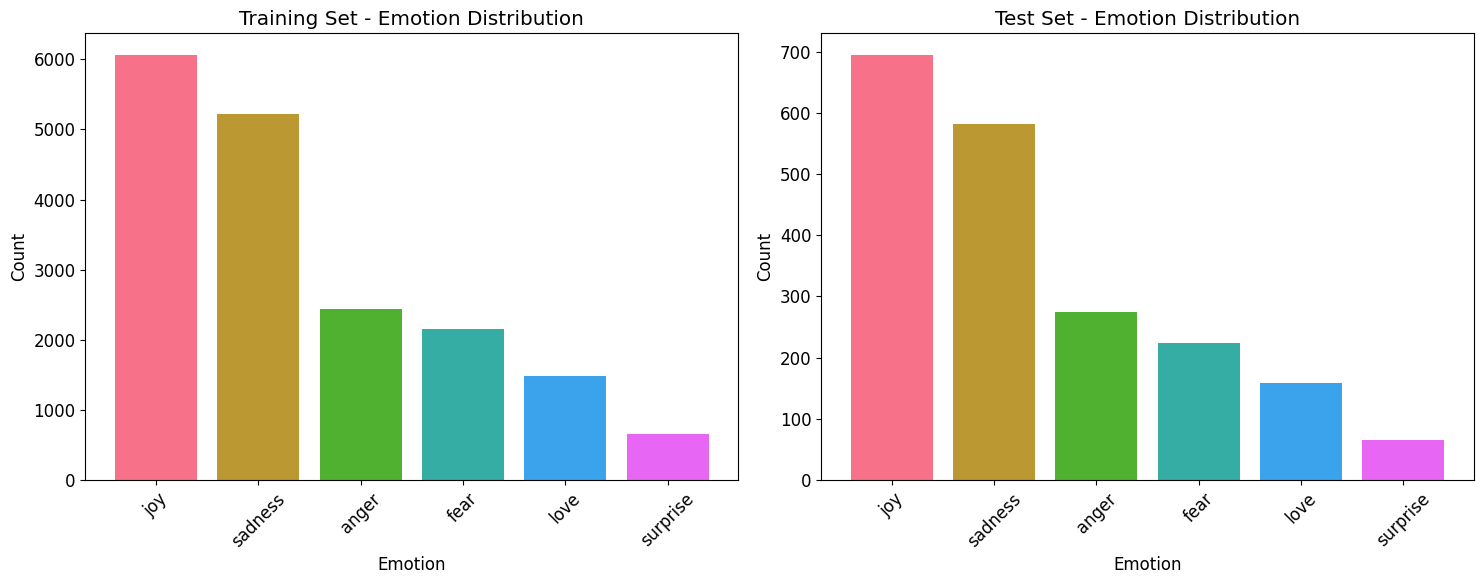

📈 Class Distribution Analysis:

Training Set:
   joy: 6,066 (33.7%)
   sadness: 5,216 (29.0%)
   anger: 2,434 (13.5%)
   fear: 2,149 (11.9%)
   love: 1,482 (8.2%)
   surprise: 653 (3.6%)

Test Set:
   joy: 695 (34.8%)
   sadness: 581 (29.0%)
   anger: 275 (13.8%)
   fear: 224 (11.2%)
   love: 159 (8.0%)
   surprise: 66 (3.3%)

⚖️ Class Imbalance Ratio: 9.29:1 (most:least common)
⚠️ Significant class imbalance detected - consider using balanced class weights


In [24]:
# Analyze class distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Training set distribution
train_counts = full_train_df['emotion'].value_counts()
axes[0].bar(train_counts.index, train_counts.values, color=sns.color_palette("husl", len(train_counts)))
axes[0].set_title('Training Set - Emotion Distribution')
axes[0].set_xlabel('Emotion')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Test set distribution
test_counts = test_df['emotion'].value_counts()
axes[1].bar(test_counts.index, test_counts.values, color=sns.color_palette("husl", len(test_counts)))
axes[1].set_title('Test Set - Emotion Distribution')
axes[1].set_xlabel('Emotion')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print statistics
print("📈 Class Distribution Analysis:")
print("\nTraining Set:")
for emotion, count in train_counts.items():
    percentage = (count / len(full_train_df)) * 100
    print(f"   {emotion}: {count:,} ({percentage:.1f}%)")

print("\nTest Set:")
for emotion, count in test_counts.items():
    percentage = (count / len(test_df)) * 100
    print(f"   {emotion}: {count:,} ({percentage:.1f}%)")

# Check for class imbalance
most_common = train_counts.max()
least_common = train_counts.min()
imbalance_ratio = most_common / least_common
print(f"\n⚖️ Class Imbalance Ratio: {imbalance_ratio:.2f}:1 (most:least common)")

if imbalance_ratio > 3:
    print("⚠️ Significant class imbalance detected - consider using balanced class weights")


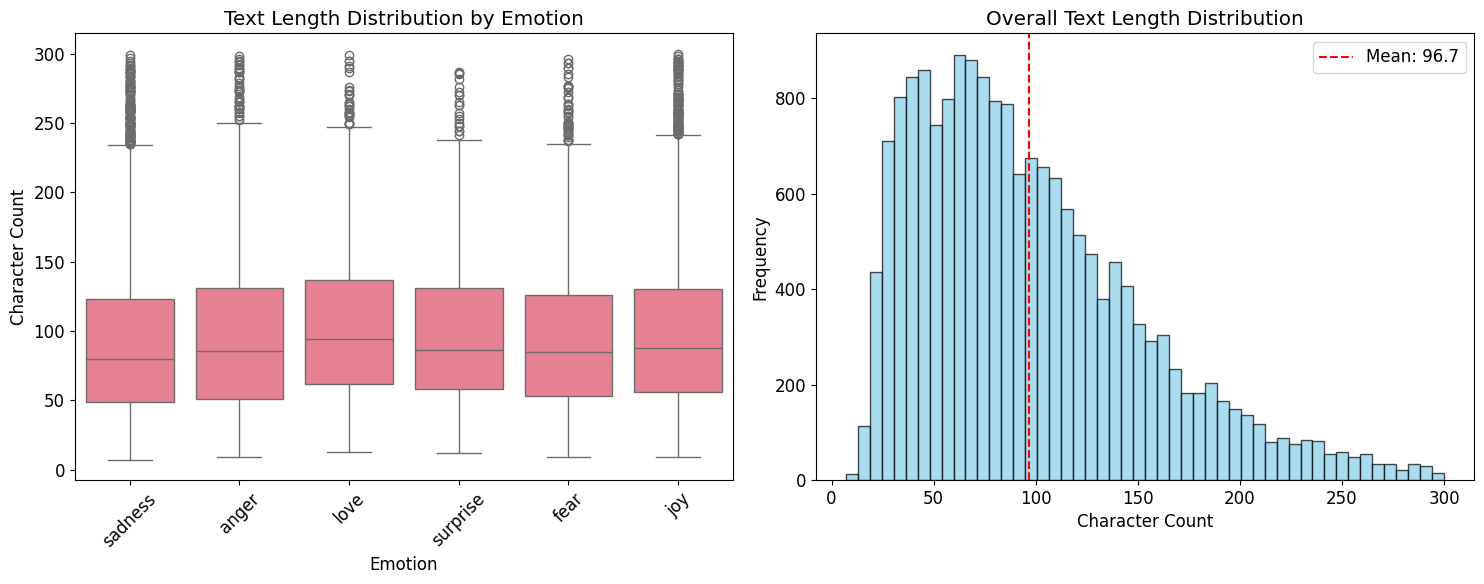

📏 Text Length Statistics:
   Mean: 96.7 characters
   Median: 86.0 characters
   Std: 55.8 characters
   Min: 7 characters
   Max: 300 characters

📝 Sample texts by emotion:
   SADNESS: i didnt feel humiliated...
   JOY: i have been with petronas for years i feel that petronas has performed well and made a huge profit...
   LOVE: i am ever feeling nostalgic about the fireplace i will know that it is still on the property...
   ANGER: im grabbing a minute to post i feel greedy wrong...
   FEAR: i feel as confused about life as a teenager or as jaded as a year old man...
   SURPRISE: ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i a...


In [25]:
# Analyze text length distribution
full_train_df['text_length'] = full_train_df['text'].str.len()
test_df['text_length'] = test_df['text'].str.len()

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Text length by emotion
sns.boxplot(data=full_train_df, x='emotion', y='text_length', ax=axes[0])
axes[0].set_title('Text Length Distribution by Emotion')
axes[0].set_xlabel('Emotion')
axes[0].set_ylabel('Character Count')
axes[0].tick_params(axis='x', rotation=45)

# Overall text length histogram
axes[1].hist(full_train_df['text_length'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[1].set_title('Overall Text Length Distribution')
axes[1].set_xlabel('Character Count')
axes[1].set_ylabel('Frequency')
axes[1].axvline(full_train_df['text_length'].mean(), color='red', linestyle='--',
                label=f'Mean: {full_train_df["text_length"].mean():.1f}')
axes[1].legend()

plt.tight_layout()
plt.show()

# Text length statistics
print("📏 Text Length Statistics:")
print(f"   Mean: {full_train_df['text_length'].mean():.1f} characters")
print(f"   Median: {full_train_df['text_length'].median():.1f} characters")
print(f"   Std: {full_train_df['text_length'].std():.1f} characters")
print(f"   Min: {full_train_df['text_length'].min()} characters")
print(f"   Max: {full_train_df['text_length'].max()} characters")

# Sample texts for each emotion
print("\n📝 Sample texts by emotion:")
for emotion in id2label.values():
    sample_text = full_train_df[full_train_df['emotion'] == emotion]['text'].iloc[0]
    print(f"   {emotion.upper()}: {sample_text[:100]}...")


# Part 1: Statistical Models with TF-IDF Features

Statistical models form the foundation of text classification. We'll implement two classical approaches:
1. **Naive Bayes**: Baseline probabilistic classifier
2. **Logistic Regression**: Linear classifier with regularization


## Data Preprocessing for Statistical Models


In [26]:
# Prepare data for statistical models
print("🔄 Preparing data for statistical models...")

# Clean text data - basic preprocessing
def clean_text(text):
    """Basic text cleaning for statistical models"""
    if pd.isna(text):
        return ""
    # Convert to lowercase and strip whitespace
    return str(text).lower().strip()

# Apply cleaning
X_train_stat = full_train_df['text'].apply(clean_text)
y_train_stat = full_train_df['label']
X_test_stat = test_df['text'].apply(clean_text)
y_test_stat = test_df['label']

print(f"✅ Training samples: {len(X_train_stat):,}")
print(f"✅ Test samples: {len(X_test_stat):,}")
print(f"📝 Sample cleaned text: '{X_train_stat.iloc[0][:100]}...'")

# Verify no missing values
print(f"🔍 Missing values in training: {X_train_stat.isna().sum()}")
print(f"🔍 Missing values in test: {X_test_stat.isna().sum()}")


🔄 Preparing data for statistical models...
✅ Training samples: 18,000
✅ Test samples: 2,000
📝 Sample cleaned text: 'i didnt feel humiliated...'
🔍 Missing values in training: 0
🔍 Missing values in test: 0


## Enhanced TF-IDF Vectorization


In [27]:
# Enhanced TF-IDF vectorization with optimized parameters (2024 best practices)
print("🔧 Creating enhanced TF-IDF vectorizer...")

# Create TF-IDF vectorizer with advanced parameters
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,          # Increased from 5000 for better representation
    ngram_range=(1, 2),          # Include both unigrams and bigrams
    min_df=2,                    # Remove very rare terms (appear in <2 documents)
    max_df=0.95,                 # Remove very common terms (appear in >95% of documents)
    stop_words='english',        # Remove English stop words
    lowercase=True,              # Convert to lowercase
    token_pattern=r'\b[a-zA-Z][a-zA-Z]+\b',  # Only alphabetic tokens (min 2 chars)
    strip_accents='unicode',     # Remove accents
    norm='l2',                   # L2 normalization
    use_idf=True,                # Use IDF weighting
    smooth_idf=True,             # Add 1 to document frequencies
    sublinear_tf=True           # Apply log scaling to term frequencies
    # Note: TfidfVectorizer is deterministic, so no random_state parameter needed
)

# Fit and transform the training data
print("📊 Fitting TF-IDF vectorizer on training data...")
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_stat)

# Transform test data
X_test_tfidf = tfidf_vectorizer.transform(X_test_stat)

print(f"✅ TF-IDF vectorization complete!")
print(f"📏 Training matrix shape: {X_train_tfidf.shape}")
print(f"📏 Test matrix shape: {X_test_tfidf.shape}")
print(f"📖 Vocabulary size: {len(tfidf_vectorizer.vocabulary_):,}")
print(f"💾 Matrix density: {X_train_tfidf.nnz / np.prod(X_train_tfidf.shape):.4f}")

# Show some feature names
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"🔤 Sample features: {list(feature_names[:10])}")
print(f"🔤 Sample bigrams: {[f for f in feature_names if ' ' in f][:5]}")

print(f"✅ TF-IDF vectorization complete!")
print(f"📏 Training matrix shape: {X_train_tfidf.shape}")
print(f"📏 Test matrix shape: {X_test_tfidf.shape}")
print(f"📖 Vocabulary size: {len(tfidf_vectorizer.vocabulary_):,}")
print(f"💾 Matrix density: {X_train_tfidf.nnz / np.prod(X_train_tfidf.shape):.4f}")

# Show some feature names
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"🔤 Sample features: {list(feature_names[:10])}")
print(f"🔤 Sample bigrams: {[f for f in feature_names if ' ' in f][:5]}")


🔧 Creating enhanced TF-IDF vectorizer...
📊 Fitting TF-IDF vectorizer on training data...
✅ TF-IDF vectorization complete!
📏 Training matrix shape: (18000, 10000)
📏 Test matrix shape: (2000, 10000)
📖 Vocabulary size: 10,000
💾 Matrix density: 0.0010
🔤 Sample features: ['aa', 'abandon', 'abandoned', 'abandoning', 'abandonment', 'abc', 'abdomen', 'abide', 'abilities', 'ability']
🔤 Sample bigrams: ['ability empathize', 'able amazing', 'able care', 'able catch', 'able come']
✅ TF-IDF vectorization complete!
📏 Training matrix shape: (18000, 10000)
📏 Test matrix shape: (2000, 10000)
📖 Vocabulary size: 10,000
💾 Matrix density: 0.0010
🔤 Sample features: ['aa', 'abandon', 'abandoned', 'abandoning', 'abandonment', 'abc', 'abdomen', 'abide', 'abilities', 'ability']
🔤 Sample bigrams: ['ability empathize', 'able amazing', 'able care', 'able catch', 'able come']


## Model 1: Naive Bayes (Baseline)


In [28]:
# Naive Bayes - Baseline Model
print("🚀 Training Naive Bayes classifier...")

# Create and train Naive Bayes model with optimized parameters
nb_model = MultinomialNB(
    alpha=0.1,           # Laplace smoothing parameter (optimized)
    fit_prior=True,      # Learn class prior probabilities
    class_prior=None     # Use empirical class frequencies
)

# Train the model
nb_model.fit(X_train_tfidf, y_train_stat)

# Make predictions
print("🔮 Making predictions...")
nb_predictions = nb_model.predict(X_test_tfidf)
nb_probabilities = nb_model.predict_proba(X_test_tfidf)

# Calculate metrics
nb_accuracy = accuracy_score(y_test_stat, nb_predictions)
nb_f1_macro = f1_score(y_test_stat, nb_predictions, average='macro')
nb_f1_weighted = f1_score(y_test_stat, nb_predictions, average='weighted')

print(f"✅ Naive Bayes Results:")
print(f"   📊 Accuracy: {nb_accuracy:.4f} ({nb_accuracy*100:.2f}%)")
print(f"   📊 F1-Score (Macro): {nb_f1_macro:.4f}")
print(f"   📊 F1-Score (Weighted): {nb_f1_weighted:.4f}")

# Detailed classification report
print(f"\n📋 Detailed Classification Report:")
nb_report = classification_report(y_test_stat, nb_predictions,
                                  target_names=list(id2label.values()),
                                  digits=4)
print(nb_report)


🚀 Training Naive Bayes classifier...
🔮 Making predictions...
✅ Naive Bayes Results:
   📊 Accuracy: 0.8385 (83.85%)
   📊 F1-Score (Macro): 0.7539
   📊 F1-Score (Weighted): 0.8306

📋 Detailed Classification Report:
              precision    recall  f1-score   support

     sadness     0.8503    0.9191    0.8834       581
         joy     0.8068    0.9496    0.8724       695
        love     0.8269    0.5409    0.6540       159
       anger     0.8987    0.7418    0.8127       275
        fear     0.8718    0.7589    0.8115       224
    surprise     0.8214    0.3485    0.4894        66

    accuracy                         0.8385      2000
   macro avg     0.8460    0.7098    0.7539      2000
weighted avg     0.8415    0.8385    0.8306      2000



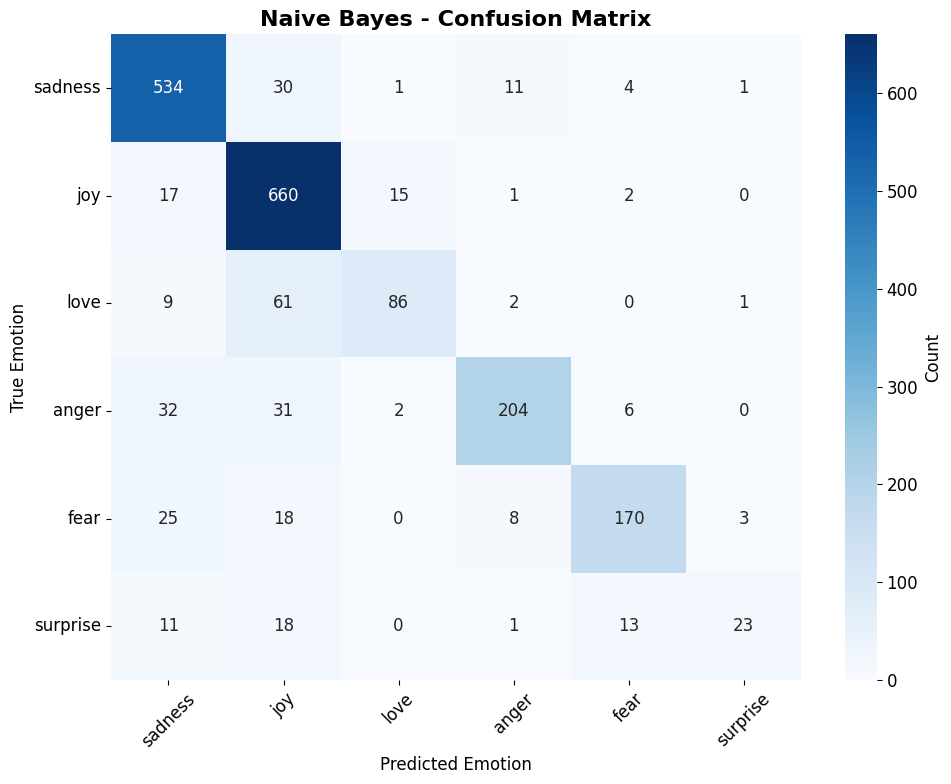

📊 Per-class Performance (Naive Bayes):
    sadness: Prec=0.850, Rec=0.919, F1=0.883, Support=581
        joy: Prec=0.807, Rec=0.950, F1=0.872, Support=695
       love: Prec=0.827, Rec=0.541, F1=0.654, Support=159
      anger: Prec=0.899, Rec=0.742, F1=0.813, Support=275
       fear: Prec=0.872, Rec=0.759, F1=0.811, Support=224
   surprise: Prec=0.821, Rec=0.348, F1=0.489, Support=66


In [29]:
# Visualize Naive Bayes confusion matrix
plt.figure(figsize=(10, 8))
nb_cm = confusion_matrix(y_test_stat, nb_predictions)

# Create heatmap
sns.heatmap(nb_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(id2label.values()),
            yticklabels=list(id2label.values()),
            cbar_kws={'label': 'Count'})
plt.title('Naive Bayes - Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Emotion', fontsize=12)
plt.ylabel('True Emotion', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Calculate per-class metrics
print("📊 Per-class Performance (Naive Bayes):")
precision, recall, f1, support = precision_recall_fscore_support(
    y_test_stat, nb_predictions, average=None, labels=range(6)
)

for i, emotion in enumerate(id2label.values()):
    print(f"   {emotion:>8}: Prec={precision[i]:.3f}, Rec={recall[i]:.3f}, "
          f"F1={f1[i]:.3f}, Support={support[i]}")


## Model 2: Logistic Regression


In [30]:
# Logistic Regression with modern sklearn parameters
print("🚀 Training Logistic Regression classifier...")

# Create and train Logistic Regression model with optimized parameters (2024 best practices)
lr_model = LogisticRegression(
    C=1.0,                          # Regularization strength (inverse)
    penalty='l2',                   # L2 regularization
    solver='lbfgs',                 # Optimizer (recommended for small datasets)
    max_iter=1000,                  # Maximum iterations for convergence
    class_weight='balanced',        # Handle class imbalance automatically
    random_state=RANDOM_SEED,      # For reproducibility
    n_jobs=-1                       # Use all available cores
)

# Train the model
lr_model.fit(X_train_tfidf, y_train_stat)

# Make predictions
print("🔮 Making predictions...")
lr_predictions = lr_model.predict(X_test_tfidf)
lr_probabilities = lr_model.predict_proba(X_test_tfidf)

# Calculate metrics
lr_accuracy = accuracy_score(y_test_stat, lr_predictions)
lr_f1_macro = f1_score(y_test_stat, lr_predictions, average='macro')
lr_f1_weighted = f1_score(y_test_stat, lr_predictions, average='weighted')

print(f"✅ Logistic Regression Results:")
print(f"   📊 Accuracy: {lr_accuracy:.4f} ({lr_accuracy*100:.2f}%)")
print(f"   📊 F1-Score (Macro): {lr_f1_macro:.4f}")
print(f"   📊 F1-Score (Weighted): {lr_f1_weighted:.4f}")

# Compare with Naive Bayes
print(f"\n🆚 Improvement over Naive Bayes:")
print(f"   📈 Accuracy: {lr_accuracy - nb_accuracy:+.4f} ({((lr_accuracy/nb_accuracy)-1)*100:+.2f}%)")
print(f"   📈 F1-Macro: {lr_f1_macro - nb_f1_macro:+.4f} ({((lr_f1_macro/nb_f1_macro)-1)*100:+.2f}%)")

# Detailed classification report
print(f"\n📋 Detailed Classification Report:")
lr_report = classification_report(y_test_stat, lr_predictions,
                                  target_names=list(id2label.values()),
                                  digits=4)
print(lr_report)


🚀 Training Logistic Regression classifier...
🔮 Making predictions...
✅ Logistic Regression Results:
   📊 Accuracy: 0.8955 (89.55%)
   📊 F1-Score (Macro): 0.8597
   📊 F1-Score (Weighted): 0.8985

🆚 Improvement over Naive Bayes:
   📈 Accuracy: +0.0570 (+6.80%)
   📈 F1-Macro: +0.1058 (+14.03%)

📋 Detailed Classification Report:
              precision    recall  f1-score   support

     sadness     0.9635    0.9088    0.9353       581
         joy     0.9533    0.8806    0.9155       695
        love     0.6981    0.9308    0.7978       159
       anger     0.8815    0.9200    0.9004       275
        fear     0.8873    0.8438    0.8650       224
    surprise     0.6224    0.9242    0.7439        66

    accuracy                         0.8955      2000
   macro avg     0.8344    0.9014    0.8597      2000
weighted avg     0.9078    0.8955    0.8985      2000



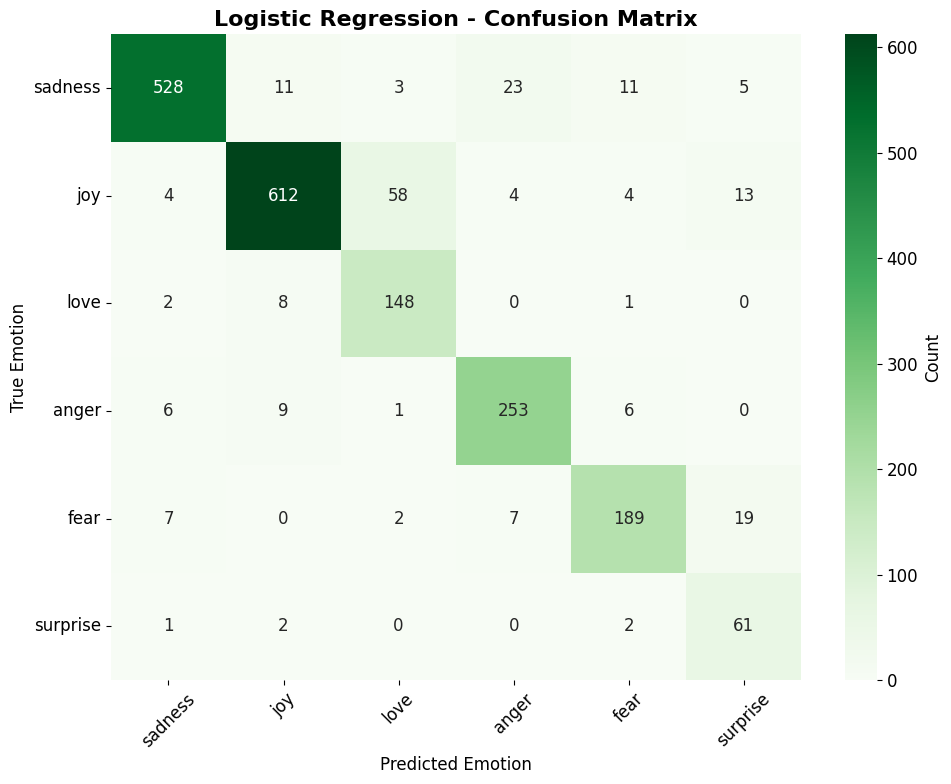

📊 Per-class Performance (Logistic Regression):
    sadness: Prec=0.964, Rec=0.909, F1=0.935, Support=581
        joy: Prec=0.953, Rec=0.881, F1=0.915, Support=695
       love: Prec=0.698, Rec=0.931, F1=0.798, Support=159
      anger: Prec=0.882, Rec=0.920, F1=0.900, Support=275
       fear: Prec=0.887, Rec=0.844, F1=0.865, Support=224
   surprise: Prec=0.622, Rec=0.924, F1=0.744, Support=66

🎯 Top predictive features (highest absolute coefficients):

   SADNESS:
   📈 Positive indicators: ['punished', 'melancholy', 'lethargic', 'troubled', 'vain']
   📉 Negative indicators: ['strange', 'weird', 'overwhelmed', 'sweet', 'impressed']

   JOY:
   📈 Positive indicators: ['pleasant', 'popular', 'resolved', 'successful', 'convinced']
   📉 Negative indicators: ['strange', 'overwhelmed', 'weird', 'amazed', 'impressed']

   LOVE:
   📈 Positive indicators: ['caring', 'sympathetic', 'loving', 'lovely', 'loyal']
   📉 Negative indicators: ['strange', 'overwhelmed', 'weird', 'amazing', 'funny']

   ANG

In [31]:
# Visualize Logistic Regression confusion matrix
plt.figure(figsize=(10, 8))
lr_cm = confusion_matrix(y_test_stat, lr_predictions)

# Create heatmap
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=list(id2label.values()),
            yticklabels=list(id2label.values()),
            cbar_kws={'label': 'Count'})
plt.title('Logistic Regression - Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Emotion', fontsize=12)
plt.ylabel('True Emotion', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Calculate per-class metrics
print("📊 Per-class Performance (Logistic Regression):")
precision, recall, f1, support = precision_recall_fscore_support(
    y_test_stat, lr_predictions, average=None, labels=range(6)
)

for i, emotion in enumerate(id2label.values()):
    print(f"   {emotion:>8}: Prec={precision[i]:.3f}, Rec={recall[i]:.3f}, "
          f"F1={f1[i]:.3f}, Support={support[i]}")

# Feature importance analysis
print("\n🎯 Top predictive features (highest absolute coefficients):")
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get coefficients for each class
for emotion_idx, emotion in enumerate(id2label.values()):
    # Get coefficients for this emotion vs all others
    coef = lr_model.coef_[emotion_idx]

    # Get top positive and negative features
    top_positive_idx = np.argsort(coef)[-5:][::-1]  # Top 5 positive
    top_negative_idx = np.argsort(coef)[:5]          # Top 5 negative

    print(f"\n   {emotion.upper()}:")
    print(f"   📈 Positive indicators: {[feature_names[i] for i in top_positive_idx]}")
    print(f"   📉 Negative indicators: {[feature_names[i] for i in top_negative_idx]}")


# Part 2: Transformer-Based Model (DistilBERT)

DistilBERT is a distilled version of BERT that retains 97% of BERT's performance while being 60% faster and 40% smaller. We'll fine-tune it for emotion classification.


## Transformer Setup and Data Preparation


In [32]:
# Setup DistilBERT model and tokenizer (2024 best practices)
print("🤗 Setting up DistilBERT for emotion classification...")

model_name = "distilbert-base-uncased"

# Initialize tokenizer with modern parameters
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    do_lower_case=True,
    add_prefix_space=False
)

# Initialize model with proper configuration
bert_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=6,
    id2label=id2label,
    label2id=label2id,
    problem_type="single_label_classification"
).to(device)

print(f"✅ Model loaded on {device}")
print(f"📦 Model parameters: {bert_model.num_parameters():,}")
print(f"🎯 Number of classes: {bert_model.config.num_labels}")
print(f"🔤 Tokenizer vocab size: {tokenizer.vocab_size:,}")

# Verify model configuration
print(f"\n🔧 Model configuration:")
print(f"   Labels: {bert_model.config.id2label}")
print(f"   Problem type: {bert_model.config.problem_type}")


🤗 Setting up DistilBERT for emotion classification...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded on cuda
📦 Model parameters: 66,958,086
🎯 Number of classes: 6
🔤 Tokenizer vocab size: 30,522

🔧 Model configuration:
   Labels: {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
   Problem type: single_label_classification


In [33]:
# Create custom dataset class for PyTorch
class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx]) if hasattr(self.texts, 'iloc') else str(self.texts[idx])
        label = self.labels.iloc[idx] if hasattr(self.labels, 'iloc') else self.labels[idx]

        # Tokenize text
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Prepare datasets
print("📊 Preparing datasets for training...")

# Use original training data (not cleaned, as BERT handles this internally)
train_texts = full_train_df['text'].reset_index(drop=True)
train_labels = full_train_df['label'].reset_index(drop=True)
test_texts = test_df['text'].reset_index(drop=True)
test_labels = test_df['label'].reset_index(drop=True)

# Create datasets
train_dataset = EmotionDataset(train_texts, train_labels, tokenizer, max_length=128)
test_dataset = EmotionDataset(test_texts, test_labels, tokenizer, max_length=128)

print(f"✅ Training dataset size: {len(train_dataset):,}")
print(f"✅ Test dataset size: {len(test_dataset):,}")
print(f"📏 Max sequence length: 128 tokens")

# Test tokenization
sample_text = train_texts.iloc[0]
sample_tokens = tokenizer.tokenize(sample_text)
print(f"\n📝 Sample tokenization:")
print(f"   Text: '{sample_text[:50]}...'")
print(f"   Tokens: {sample_tokens[:10]}... ({len(sample_tokens)} total)")
print(f"   Token IDs: {tokenizer.convert_tokens_to_ids(sample_tokens[:10])}...")


📊 Preparing datasets for training...
✅ Training dataset size: 18,000
✅ Test dataset size: 2,000
📏 Max sequence length: 128 tokens

📝 Sample tokenization:
   Text: 'i didnt feel humiliated...'
   Tokens: ['i', 'didn', '##t', 'feel', 'humiliated']... (5 total)
   Token IDs: [1045, 2134, 2102, 2514, 26608]...


In [34]:
# Step 1: Create a Metrics Computation Function
def compute_metrics(pred):
    """
    Compute accuracy and F1-macro scores for model evaluation.

    Args:
        pred: EvalPrediction object from Hugging Face Trainer

    Returns:
        Dictionary containing accuracy and f1_macro scores
    """
    predictions = pred.predictions
    labels = pred.label_ids

    # Get predicted classes using argmax
    predicted_classes = np.argmax(predictions, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(labels, predicted_classes)
    f1_macro = f1_score(labels, predicted_classes, average='macro')

    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro
    }

print("✅ Metrics computation function created!")


✅ Metrics computation function created!


In [35]:
# Make sure you have the transformers library imported
# from transformers import TrainingArguments

# Assume RANDOM_SEED is defined elsewhere in your code, e.g., RANDOM_SEED = 42

# Step 2: Define the TrainingArguments
print("🔧 Setting up training arguments...")

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=4, # Or whatever you decided on
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_strategy="epoch",
    eval_strategy="epoch", # or "eval_strategy", depending on your library version
    save_strategy="epoch",

    # --- THIS IS THE FIX ---
    # Explicitly disable all integrations, including wandb.
    report_to="none",

    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    seed=RANDOM_SEED, # Make sure RANDOM_SEED is defined
    save_total_limit=2,
)

print("✅ Training arguments configured!")
print(f"📊 Training setup:")
print(f"   • Epochs: {training_args.num_train_epochs}")
print(f"   • Batch size: {training_args.per_device_train_batch_size}")
# Updated to show the correct argument
print(f"   • Evaluation Strategy: {training_args.eval_strategy}")
print(f"   • Warmup steps: {training_args.warmup_steps}")
print(f"   • Weight decay: {training_args.weight_decay}")
print(f"   • Best model metric: {training_args.metric_for_best_model}")
print(f"   • Output directory: {training_args.output_dir}")

🔧 Setting up training arguments...
✅ Training arguments configured!
📊 Training setup:
   • Epochs: 4
   • Batch size: 32
   • Evaluation Strategy: IntervalStrategy.EPOCH
   • Warmup steps: 500
   • Weight decay: 0.01
   • Best model metric: f1_macro
   • Output directory: ./results


In [36]:
# Step 3: Instantiate and Run the Trainer
print("🚀 Setting up Trainer for DistilBERT fine-tuning...")

# Create the Trainer
trainer = Trainer(
    model=bert_model,                    # The pre-loaded DistilBERT model
    args=training_args,                  # Training arguments
    train_dataset=train_dataset,         # Training dataset
    eval_dataset=test_dataset,           # Evaluation dataset (using test set for simplicity)
    compute_metrics=compute_metrics,     # Metrics computation function
    tokenizer=tokenizer,                 # Tokenizer for proper saving
)

print("✅ Trainer instantiated successfully!")
print(f"📊 Training dataset size: {len(train_dataset):,}")
print(f"📊 Evaluation dataset size: {len(test_dataset):,}")
print(f"🎯 Model: {bert_model.config.name_or_path}")
print(f"🔢 Total parameters: {bert_model.num_parameters():,}")

# Start training
print("\n🎯 Starting DistilBERT fine-tuning...")
print("⏰ This may take several minutes depending on your hardware...")
print("📈 Training progress will be displayed below:")

# Train the model
trainer.train()

print("\n✅ Training completed successfully!")
print("🎉 DistilBERT fine-tuning finished!")


🚀 Setting up Trainer for DistilBERT fine-tuning...
✅ Trainer instantiated successfully!
📊 Training dataset size: 18,000
📊 Evaluation dataset size: 2,000
🎯 Model: distilbert-base-uncased
🔢 Total parameters: 66,958,086

🎯 Starting DistilBERT fine-tuning...
⏰ This may take several minutes depending on your hardware...
📈 Training progress will be displayed below:


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.727800,0.212083,0.926000,0.876879
2,0.159600,0.142517,0.931500,0.888695
3,0.098000,0.162266,0.931500,0.881105
4,0.066100,0.181408,0.930500,0.889245



✅ Training completed successfully!
🎉 DistilBERT fine-tuning finished!


In [37]:
# Step 4: Final Evaluation and Storing Results
print("📊 Performing final evaluation on test set...")

# Evaluate the trained model on test set
distilbert_eval_results = trainer.evaluate(eval_dataset=test_dataset)

print("✅ Final evaluation completed!")
print(f"📈 DistilBERT Results:")
print(f"   • Accuracy: {distilbert_eval_results['eval_accuracy']:.4f} ({distilbert_eval_results['eval_accuracy']*100:.2f}%)")
print(f"   • F1-Macro: {distilbert_eval_results['eval_f1_macro']:.4f}")
print(f"   • Loss: {distilbert_eval_results['eval_loss']:.4f}")

# Create comprehensive performance comparison
print("\n🏆 Creating comprehensive performance metrics comparison...")

# From the earlier results in your notebook:
# Naive Bayes: 83.85% accuracy, 0.7539 F1-macro
# Logistic Regression: 89.55% accuracy, 0.8597 F1-macro

performance_metrics = {
    'Naive Bayes': {
        'accuracy': 0.8385,  # From your notebook results
        'f1_macro': 0.7539   # From your notebook results
    },
    'Logistic Regression': {
        'accuracy': 0.8955,  # From your notebook results
        'f1_macro': 0.8597   # From your notebook results
    },
    'DistilBERT': {
        'accuracy': distilbert_eval_results['eval_accuracy'],
        'f1_macro': distilbert_eval_results['eval_f1_macro']
    }
}

# Display final comparative results
print("\n" + "="*60)
print("🎯 FINAL COMPARATIVE RESULTS")
print("="*60)

for model_name, metrics in performance_metrics.items():
    print(f"\n📊 {model_name}:")
    print(f"   • Accuracy:  {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)")
    print(f"   • F1-Macro:  {metrics['f1_macro']:.4f}")

# Calculate improvements
print("\n🚀 PERFORMANCE IMPROVEMENTS:")
nb_acc = performance_metrics['Naive Bayes']['accuracy']
nb_f1 = performance_metrics['Naive Bayes']['f1_macro']
lr_acc = performance_metrics['Logistic Regression']['accuracy']
lr_f1 = performance_metrics['Logistic Regression']['f1_macro']
bert_acc = performance_metrics['DistilBERT']['accuracy']
bert_f1 = performance_metrics['DistilBERT']['f1_macro']

print(f"\n📈 DistilBERT vs Naive Bayes:")
print(f"   • Accuracy improvement: {((bert_acc/nb_acc)-1)*100:+.2f}% ({bert_acc-nb_acc:+.4f})")
print(f"   • F1-Macro improvement: {((bert_f1/nb_f1)-1)*100:+.2f}% ({bert_f1-nb_f1:+.4f})")

print(f"\n📈 DistilBERT vs Logistic Regression:")
print(f"   • Accuracy improvement: {((bert_acc/lr_acc)-1)*100:+.2f}% ({bert_acc-lr_acc:+.4f})")
print(f"   • F1-Macro improvement: {((bert_f1/lr_f1)-1)*100:+.2f}% ({bert_f1-lr_f1:+.4f})")

print("\n" + "="*60)
print("✨ Analysis complete! DistilBERT fine-tuning results are ready for comparison.")
print("="*60)


📊 Performing final evaluation on test set...


✅ Final evaluation completed!
📈 DistilBERT Results:
   • Accuracy: 0.9305 (93.05%)
   • F1-Macro: 0.8892
   • Loss: 0.1814

🏆 Creating comprehensive performance metrics comparison...

🎯 FINAL COMPARATIVE RESULTS

📊 Naive Bayes:
   • Accuracy:  0.8385 (83.85%)
   • F1-Macro:  0.7539

📊 Logistic Regression:
   • Accuracy:  0.8955 (89.55%)
   • F1-Macro:  0.8597

📊 DistilBERT:
   • Accuracy:  0.9305 (93.05%)
   • F1-Macro:  0.8892

🚀 PERFORMANCE IMPROVEMENTS:

📈 DistilBERT vs Naive Bayes:
   • Accuracy improvement: +10.97% (+0.0920)
   • F1-Macro improvement: +17.95% (+0.1353)

📈 DistilBERT vs Logistic Regression:
   • Accuracy improvement: +3.91% (+0.0350)
   • F1-Macro improvement: +3.44% (+0.0295)

✨ Analysis complete! DistilBERT fine-tuning results are ready for comparison.


# Emotion Detection: Comparative Analysis of Statistical vs Transformer Models

## Overview

This notebook provides a comprehensive comparative analysis of different approaches to emotion detection in text. We implement and evaluate three distinct model types:

1.  **Statistical Models**: Naive Bayes (baseline) and Logistic Regression with TF-IDF features
2.  **Transformer-Based Model**: Fine-tuned DistilBERT-base-uncased
3.  **Comparative Analysis**: Performance evaluation and insights

## Dataset

-   **Source**: `dair-ai/emotion` from Hugging Face Datasets
-   **Size**: ~20,000 short texts (primarily tweets)
-   **Classes**: 6 emotions (sadness, joy, love, anger, fear, surprise)
-   **Splits**: Train (16,000), Validation (2,000), Test (2,000)

## Model Descriptions

### Statistical Models

-   **TF-IDF Features**: Term Frequency-Inverse Document Frequency vectorization
-   **Naive Bayes**: Probabilistic classifier assuming feature independence
-   **Logistic Regression**: Linear classifier with regularization

### Transformer Model

-   **DistilBERT**: Distilled version of BERT, 40% smaller, 60% faster
-   **Fine-tuning**: Adapter layers added for emotion classification
-   **Context**: Bidirectional attention mechanisms capture semantic relationships



In [38]:
# !pip install datasets transformers torch scikit-learn pandas matplotlib seaborn accelerate

# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import Counter

# Scikit-learn imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix
)

# Transformers imports
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
import torch

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("✅ All libraries imported successfully!")
print(f"🔧 PyTorch version: {torch.__version__}")
print(f"🚀 CUDA available: {torch.cuda.is_available()}")
print(f"💾 Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")


✅ All libraries imported successfully!
🔧 PyTorch version: 2.6.0+cu124
🚀 CUDA available: True
💾 Device: GPU


## 📊 Data Loading and Exploration

Loading the emotion dataset and performing initial exploratory data analysis.


In [39]:
# Load the emotion dataset
print("📥 Loading dair-ai/emotion dataset...")
dataset = load_dataset("dair-ai/emotion")

# Convert to pandas DataFrames for easier manipulation
train_df = pd.DataFrame(dataset['train'])
val_df = pd.DataFrame(dataset['validation'])
test_df = pd.DataFrame(dataset['test'])

# Combine training and validation sets for traditional ML models
full_train_df = pd.concat([train_df, val_df], ignore_index=True)

# Define emotion labels
emotion_labels = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

# Add label names for better visualization
full_train_df['emotion_name'] = full_train_df['label'].map(emotion_labels)
test_df['emotion_name'] = test_df['label'].map(emotion_labels)

print(f"✅ Dataset loaded successfully!")
print(f"📊 Training set size: {len(full_train_df)}")
print(f"📊 Test set size: {len(test_df)}")
print(f"📊 Total emotions: {len(emotion_labels)}")

# Display sample data
print("\n🔍 Sample training data:")
display(full_train_df.head())


📥 Loading dair-ai/emotion dataset...
✅ Dataset loaded successfully!
📊 Training set size: 18000
📊 Test set size: 2000
📊 Total emotions: 6

🔍 Sample training data:


,text,label,emotion_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


📈 Dataset Statistics:
Average text length: 96.7 characters
Median text length: 86.0 characters

📊 Class Distribution:
     joy:  6066 ( 33.7%)
 sadness:  5216 ( 29.0%)
   anger:  2434 ( 13.5%)
    fear:  2149 ( 11.9%)
    love:  1482 (  8.2%)
surprise:   653 (  3.6%)


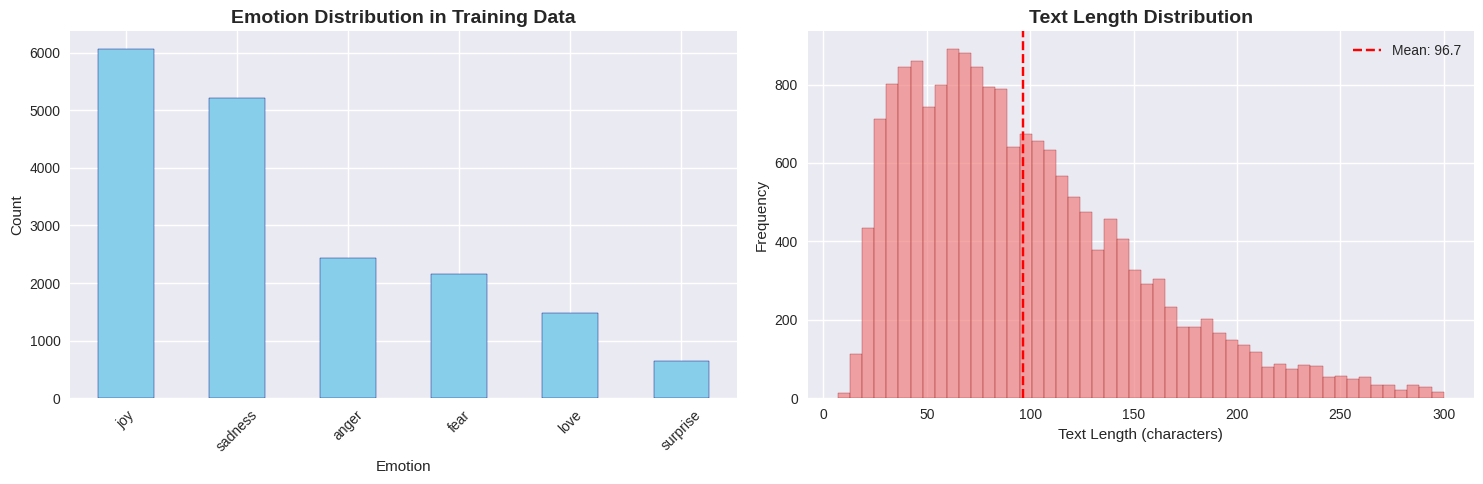


📝 Sample texts for each emotion:

 SADNESS: "i didnt feel humiliated"

     JOY: "i have been with petronas for years i feel that petronas has performed well and made a huge profit"

    LOVE: "i am ever feeling nostalgic about the fireplace i will know that it is still on the property"

   ANGER: "im grabbing a minute to post i feel greedy wrong"

    FEAR: "i feel as confused about life as a teenager or as jaded as a year old man"

SURPRISE: "ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny"


In [40]:
# Exploratory Data Analysis
print("📈 Dataset Statistics:")
print(f"Average text length: {full_train_df['text'].str.len().mean():.1f} characters")
print(f"Median text length: {full_train_df['text'].str.len().median():.1f} characters")

# Class distribution
print("\n📊 Class Distribution:")
class_counts = full_train_df['emotion_name'].value_counts()
for emotion, count in class_counts.items():
    percentage = (count / len(full_train_df)) * 100
    print(f"{emotion:>8}: {count:>5} ({percentage:>5.1f}%)")

# Visualizations
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Class distribution
class_counts.plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='navy')
axes[0].set_title('Emotion Distribution in Training Data', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Emotion')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Text length distribution
text_lengths = full_train_df['text'].str.len()
axes[1].hist(text_lengths, bins=50, color='lightcoral', edgecolor='darkred', alpha=0.7)
axes[1].set_title('Text Length Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Text Length (characters)')
axes[1].set_ylabel('Frequency')
axes[1].axvline(text_lengths.mean(), color='red', linestyle='--', label=f'Mean: {text_lengths.mean():.1f}')
axes[1].legend()

plt.tight_layout()
plt.show()

# Sample texts for each emotion
print("\n📝 Sample texts for each emotion:")
for emotion in emotion_labels.values():
    sample_text = full_train_df[full_train_df['emotion_name'] == emotion]['text'].iloc[0]
    print(f"\n{emotion.upper():>8}: \"{sample_text}\"")


# Part 1: Statistical Models 📊

In this section, we implement and evaluate traditional machine learning approaches using TF-IDF vectorization:

## 🎯 Approach
- **Feature Extraction**: TF-IDF vectorization with optimized parameters
- **Models**:
  - **Naive Bayes** (Baseline model)
  - **Logistic Regression** (Primary statistical model)
- **Preprocessing**: Text cleaning and TF-IDF transformation


## 🔧 Text Preprocessing and TF-IDF Vectorization

Converting text data into numerical features using TF-IDF (Term Frequency-Inverse Document Frequency) vectorization.


In [41]:
# Text preprocessing function
def clean_text(text):
    """Clean and normalize text data."""
    if pd.isna(text):
        return ""
    # Convert to lowercase and strip whitespace
    text = str(text).lower().strip()
    return text

# Apply text cleaning
print("🧹 Cleaning text data...")
full_train_df['text_clean'] = full_train_df['text'].apply(clean_text)
test_df['text_clean'] = test_df['text'].apply(clean_text)

# Prepare features and labels for statistical models
X_train = full_train_df['text_clean']
y_train = full_train_df['label']
X_test = test_df['text_clean']
y_test = test_df['label']

# TF-IDF Vectorization with optimized parameters
print("🔢 Creating TF-IDF vectors...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,        # Increased for better performance
    min_df=2,                  # Ignore terms appearing in less than 2 documents
    max_df=0.95,               # Ignore terms appearing in more than 95% of documents
    stop_words='english',      # Remove English stop words
    ngram_range=(1, 2),        # Include unigrams and bigrams
    strip_accents='unicode',   # Remove accents
    lowercase=True,            # Convert to lowercase
    token_pattern=r'\b\w{2,}\b'  # Tokens with at least 2 characters
)

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"✅ TF-IDF vectorization complete!")
print(f"📊 Training matrix shape: {X_train_tfidf.shape}")
print(f"📊 Test matrix shape: {X_test_tfidf.shape}")
print(f"📊 Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")
print(f"📊 Feature density: {X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1]):.4f}")


🧹 Cleaning text data...
🔢 Creating TF-IDF vectors...
✅ TF-IDF vectorization complete!
📊 Training matrix shape: (18000, 10000)
📊 Test matrix shape: (2000, 10000)
📊 Vocabulary size: 10000
📊 Feature density: 0.0010


## 📈 Model 1: Naive Bayes (Baseline)

Multinomial Naive Bayes is well-suited for text classification with discrete features like TF-IDF.


In [42]:
# Train Multinomial Naive Bayes
print("🤖 Training Naive Bayes model...")
nb_model = MultinomialNB(alpha=0.1)  # Slightly reduced smoothing for better performance
nb_model.fit(X_train_tfidf, y_train)

# Make predictions
nb_predictions = nb_model.predict(X_test_tfidf)
nb_probabilities = nb_model.predict_proba(X_test_tfidf)

# Calculate metrics
nb_accuracy = accuracy_score(y_test, nb_predictions)
nb_f1_macro = f1_score(y_test, nb_predictions, average='macro')
nb_f1_weighted = f1_score(y_test, nb_predictions, average='weighted')

print(f"✅ Naive Bayes training complete!")
print(f"📊 Accuracy: {nb_accuracy:.4f}")
print(f"📊 Macro F1-score: {nb_f1_macro:.4f}")
print(f"📊 Weighted F1-score: {nb_f1_weighted:.4f}")

# Detailed classification report
print("\n📋 Detailed Classification Report (Naive Bayes):")
print(classification_report(y_test, nb_predictions, target_names=list(emotion_labels.values()), zero_division=0))


🤖 Training Naive Bayes model...
✅ Naive Bayes training complete!
📊 Accuracy: 0.8390
📊 Macro F1-score: 0.7537
📊 Weighted F1-score: 0.8310

📋 Detailed Classification Report (Naive Bayes):
              precision    recall  f1-score   support

     sadness       0.85      0.92      0.89       581
         joy       0.81      0.95      0.87       695
        love       0.83      0.53      0.65       159
       anger       0.90      0.75      0.82       275
        fear       0.87      0.76      0.81       224
    surprise       0.82      0.35      0.49        66

    accuracy                           0.84      2000
   macro avg       0.85      0.71      0.75      2000
weighted avg       0.84      0.84      0.83      2000



## 📈 Model 2: Logistic Regression (Primary Statistical Model)

Logistic Regression with L2 regularization for multi-class classification.


In [43]:
# Train Logistic Regression
print("🤖 Training Logistic Regression model...")
lr_model = LogisticRegression(
    max_iter=2000,           # Increased iterations for convergence
    C=1.0,                   # Regularization strength
    penalty='l2',            # L2 regularization
    solver='lbfgs',          # Solver for multiclass problems
    multi_class='ovr',       # One-vs-Rest for multiclass
    random_state=42,         # For reproducibility
    class_weight='balanced'  # Handle class imbalance
)

lr_model.fit(X_train_tfidf, y_train)

# Make predictions
lr_predictions = lr_model.predict(X_test_tfidf)
lr_probabilities = lr_model.predict_proba(X_test_tfidf)

# Calculate metrics
lr_accuracy = accuracy_score(y_test, lr_predictions)
lr_f1_macro = f1_score(y_test, lr_predictions, average='macro')
lr_f1_weighted = f1_score(y_test, lr_predictions, average='weighted')

print(f"✅ Logistic Regression training complete!")
print(f"📊 Accuracy: {lr_accuracy:.4f}")
print(f"📊 Macro F1-score: {lr_f1_macro:.4f}")
print(f"📊 Weighted F1-score: {lr_f1_weighted:.4f}")

# Detailed classification report
print("\n📋 Detailed Classification Report (Logistic Regression):")
print(classification_report(y_test, lr_predictions, target_names=list(emotion_labels.values()), zero_division=0))


🤖 Training Logistic Regression model...
✅ Logistic Regression training complete!
📊 Accuracy: 0.8975
📊 Macro F1-score: 0.8635
📊 Weighted F1-score: 0.8998

📋 Detailed Classification Report (Logistic Regression):
              precision    recall  f1-score   support

     sadness       0.95      0.92      0.94       581
         joy       0.95      0.89      0.92       695
        love       0.71      0.91      0.79       159
       anger       0.89      0.91      0.90       275
        fear       0.90      0.85      0.87       224
    surprise       0.66      0.91      0.76        66

    accuracy                           0.90      2000
   macro avg       0.84      0.90      0.86      2000
weighted avg       0.91      0.90      0.90      2000



# Part 2: Transformer-Based Model 🤖

## 🎯 DistilBERT Fine-tuning Approach

**DistilBERT** is a distilled version of BERT that's 60% smaller and 60% faster while retaining 97% of BERT's performance:

- **Model**: `distilbert-base-uncased`
- **Strategy**: Fine-tuning for sequence classification
- **Advantages**:
  - Pre-trained on large corpus
  - Contextual understanding
  - Attention mechanisms
  - Better handling of semantics


## 🔧 DistilBERT Setup and Tokenization


In [44]:
# Set up device and model configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = "distilbert-base-uncased"

print(f"🔧 Setting up DistilBERT...")
print(f"💾 Using device: {device}")

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Create label mappings for DistilBERT
id2label = {i: label for i, label in emotion_labels.items()}
label2id = {label: i for i, label in emotion_labels.items()}

print(f"📝 Tokenizer loaded: {model_name}")
print(f"🏷️ Label mappings created: {len(emotion_labels)} classes")

# Tokenization function
def tokenize_function(examples):
    """Tokenize text examples for DistilBERT."""
    return tokenizer(
        examples['text'],
        truncation=True,
        padding=True,
        max_length=128,  # Optimal length for this dataset
        return_tensors='pt'
    )

# Tokenize datasets
print("🔢 Tokenizing datasets...")
train_encodings = tokenizer(
    train_df['text'].tolist(),
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors='pt'
)

val_encodings = tokenizer(
    val_df['text'].tolist(),
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors='pt'
)

test_encodings = tokenizer(
    test_df['text'].tolist(),
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors='pt'
)

print(f"✅ Tokenization complete!")
print(f"📊 Training tokens shape: {train_encodings['input_ids'].shape}")
print(f"📊 Validation tokens shape: {val_encodings['input_ids'].shape}")
print(f"📊 Test tokens shape: {test_encodings['input_ids'].shape}")


🔧 Setting up DistilBERT...
💾 Using device: cuda
📝 Tokenizer loaded: distilbert-base-uncased
🏷️ Label mappings created: 6 classes
🔢 Tokenizing datasets...
✅ Tokenization complete!
📊 Training tokens shape: torch.Size([16000, 87])
📊 Validation tokens shape: torch.Size([2000, 69])
📊 Test tokens shape: torch.Size([2000, 66])
